### Optimizing a mathematical function using the GEO algorithm leveraging a VAE generative model

In [ ]:
!pip install qiskit_algorithms
!pip install pylatexenc
!pip install qiskit_machine_learning

#### Define functions for plotting the training

In [5]:
from IPython.display import clear_output
import matplotlib.pyplot as plt

def plot_training_progress(generator_loss_values, discriminator_loss_values, objective_values):
    if len(generator_loss_values) < 2:
        return

    clear_output(wait=True)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 9))

    # Plot Generator and Discriminator Loss
    ax1.set_title("Loss")
    ax1.plot(generator_loss_values, label="Generator Loss", color="blue")
    ax1.plot(discriminator_loss_values, label="Discriminator Loss", color="red")
    ax1.legend(loc='best')
    ax1.set_xlabel("Iterations")
    ax1.set_ylabel("Loss")
    ax1.grid()

    # Plot Objective Values
    ax2.set_title("Objective Values")
    ax2.plot(objective_values, label="Objective Value", color="green")
    ax2.set_xlabel("Iterations")
    ax2.set_ylabel("Objective Value")
    ax2.grid()

    plt.show()

#### Implementing the GEO algorithm using a QuantumGAN to optimize f(x) = $\sqrt{x_1^2 + x_2^2 + \dots + x_{5}^2}$

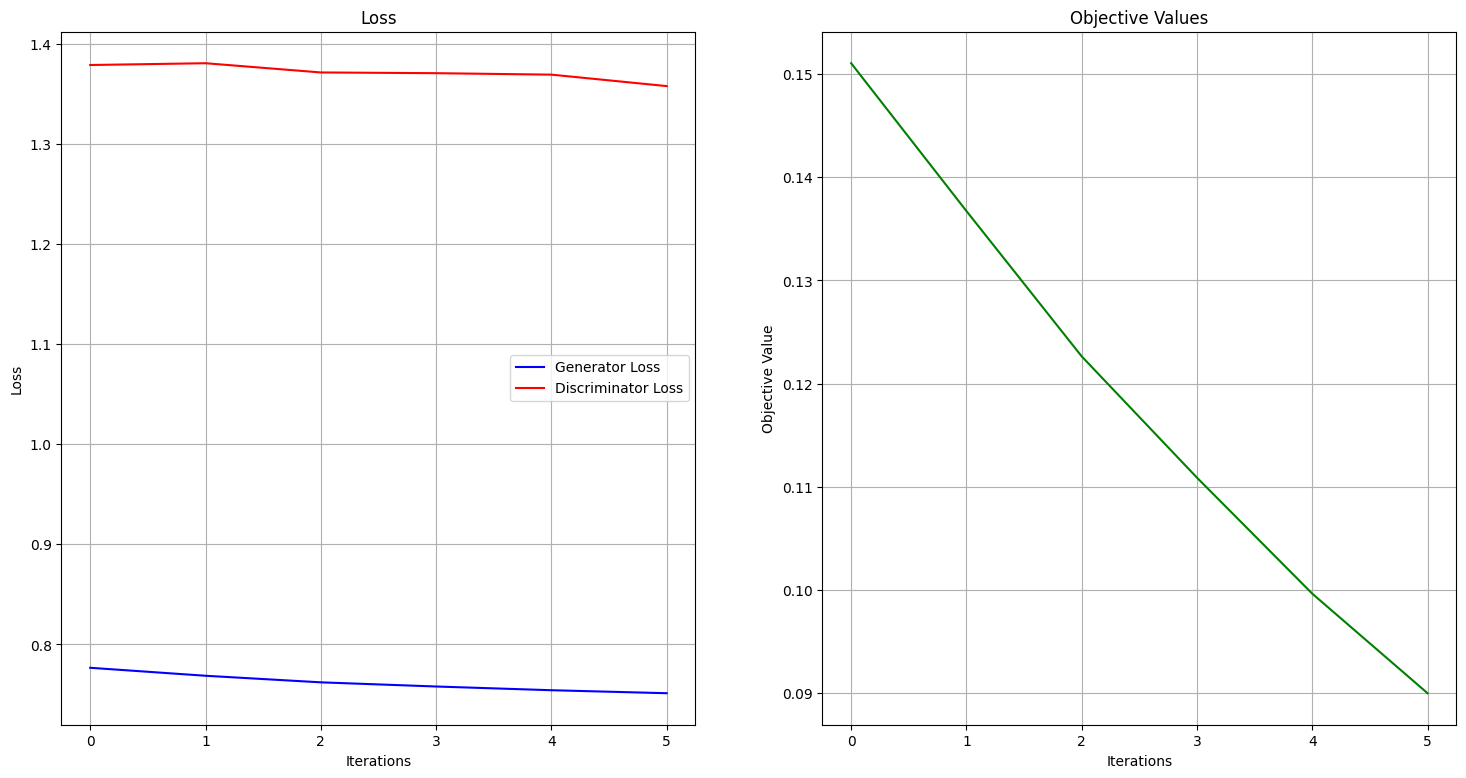

G Loss: 0.7512, D Loss: 1.3579:  15%|█▌        | 6/40 [43:01<4:30:58, 478.19s/it]

In [ ]:
import torch
import numpy as np
from qiskit_algorithms.utils import algorithm_globals
from scipy.stats import norm
from qiskit import QuantumCircuit
from qiskit.circuit.library import EfficientSU2
from torch import nn
from qiskit.primitives import Sampler
from qiskit_machine_learning.connectors import TorchConnector
from qiskit_machine_learning.neural_networks import SamplerQNN
from torch.optim import Adam
from tqdm import tqdm

device = "cuda" if torch.cuda.is_available() else 'cpu'

generator_loss_values = []
discriminator_loss_values = []
objective_values_per_epoch = []

class QuantumGAN:
    def __init__(self, num_dim=1, num_discrete_values=16, shots=10000):
        self.num_dim = num_dim
        self.num_discrete_values = num_discrete_values
        self.num_qubits = num_dim * int(np.log2(num_discrete_values))

        # Quantum Circuit Setup
        self.qc = self._create_quantum_circuit()
        self.sampler = Sampler(options={"shots": shots, "seed": algorithm_globals.random_seed})

        # Generator and Discriminator
        self.generator = self._create_generator().to(device)
        self.discriminator = self._create_discriminator().to(device)

        # Optimizers
        self.generator_optimizer = Adam(self.generator.parameters(), lr=0.01, betas=(0.7, 0.999), weight_decay=0.005)
        self.discriminator_optimizer = Adam(self.discriminator.parameters(), lr=0.01, betas=(0.7, 0.999), weight_decay=0.005)

        self.criterion = nn.BCELoss()

    def _create_quantum_circuit(self):
        qc = QuantumCircuit(self.num_qubits)
        qc.h(range(self.num_qubits))
        ansatz = EfficientSU2(self.num_qubits, reps=5)
        qc.compose(ansatz, inplace=True)
        return qc

    def _create_generator(self):
        qnn = SamplerQNN(
            circuit=self.qc,
            sampler=self.sampler,
            input_params=[],
            weight_params=self.qc.parameters,
            sparse=False,
        )
        initial_weights = algorithm_globals.random.random(self.qc.num_parameters)
        return TorchConnector(qnn, initial_weights)

    def _create_discriminator(self):
        return nn.Sequential(
            nn.Linear(5, 8),  # Input dimension must match the generator output
            nn.LeakyReLU(0.2),
            nn.Linear(8, 1),
            nn.Sigmoid()
        )

    def generate_samples(self, batch_size=64):
        samples = []
        for _ in range(batch_size):
            sample = self.generator()[:5].to(device)
            samples.append(sample)
        return torch.stack(samples).float().to(device)

    def objective_function(self, samples):
        return torch.sqrt(torch.square(samples).sum(dim=1)).to(device)

    def train(self, num_epochs=5, batch_size=64):
        # Initialize the seed with random values
        initial_seed = torch.rand(1000, 5, device=device) * 2 - 1

        pbar = tqdm(range(num_epochs))
        objective_values_per_epoch = []
        discriminator_loss_values = []
        generator_loss_values = []

        for epoch in pbar:
            # Update initial seed based on GEO algorithm
            # Select top-performing samples from previous iteration

            if epoch > 0:
                # Sort generated samples by objective function values
                generated_samples = self.generate_samples(1000)
                objective_values = self.objective_function(generated_samples)

                top_indices = torch.topk(objective_values, k=250).indices
                top_samples = generated_samples[top_indices]

                # Update initial seed with top 25% samples
                initial_seed = top_samples
                initial_seed = torch.cat([
                    initial_seed,
                    torch.rand(750, 5, device=device) * 2 - 1  # add some randomness to avoid constant ground value
                ])

            # Discriminator Training
            self.discriminator_optimizer.zero_grad()

            real_samples = initial_seed[torch.randperm(initial_seed.size(0))[:batch_size]]
            real_labels = torch.ones(batch_size, 1, device=device)

            fake_samples = self.generate_samples(batch_size)
            fake_labels = torch.zeros(batch_size, 1, device=device)

            d_real_output = self.discriminator(real_samples)
            d_real_loss = self.criterion(d_real_output, real_labels)

            d_fake_output = self.discriminator(fake_samples)
            d_fake_loss = self.criterion(d_fake_output, fake_labels)

            d_loss = d_real_loss + d_fake_loss
            d_loss.backward()
            self.discriminator_optimizer.step()
            discriminator_loss_values.append(d_loss.item())

            # Generator Training
            self.generator_optimizer.zero_grad()

            generated_samples = self.generate_samples(batch_size)
            g_fake_output = self.discriminator(generated_samples)

            objective_values = self.objective_function(generated_samples)
            g_loss = self.criterion(g_fake_output, real_labels) + torch.mean(objective_values)

            g_loss.backward()
            self.generator_optimizer.step()
            generator_loss_values.append(g_loss.item())

            # Log the mean objective value for this epoch
            mean_objective_value = torch.mean(objective_values).item()
            objective_values_per_epoch.append(mean_objective_value)

            plot_training_progress(generator_loss_values, discriminator_loss_values, objective_values_per_epoch)

            # Progress tracking
            pbar.set_description(f"G Loss: {g_loss.item():.4f}, D Loss: {d_loss.item():.4f}")

        # Plotting the results
        plt.figure(figsize=(10, 6))
        plt.plot(range(1, num_epochs + 1), objective_values_per_epoch, marker='o', label='Objective Value')
        plt.xlabel('Epoch')
        plt.ylabel('Mean Objective Value')
        plt.title('Objective Values vs Epochs')
        plt.legend()
        plt.grid(True)
        plt.show()

        return initial_seed

gan = QuantumGAN()
final_seed = gan.train(num_epochs=40)